# Avaliando o MNIST Dataset usando MLP do scikit-learn

Importações necessárias para avaliar o dataset.

* numpy - Para interagir com o dataset
* sklearn - Para importar o MultiLayer Perceptron
* matplotlib - Plotar gráficos

In [25]:
%matplotlib inline

import warnings
import random
import json
from timeit import default_timer as timer

import numpy as np

from sklearn.neural_network import MLPClassifier
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
from sklearn.datasets.base import get_data_home 
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10, 10)



Definindo tamanho (em porcentagem) do Dataset

In [ ]:
TRANING_DATASET_SIZE = 0.8
TEST_DATASET_SIZE = 0.2

O código a seguir ignora os warnings (por conta de funções deprecated no scikit-learn que sujam a saida)

Em seguida, baixamos o dataset MNIST original que vai ser salvo na pasta home do sckit-learn

In [ ]:

#Ignorando os warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
print('Downloading MNIST data')
print(f"Downloading at: {get_data_home()}")
mnist_dataset = fetch_mldata('MNIST original')
print('Downloaded and loaded!')
    

* Separando os dados dos resultados reais (targets)
* Em seguida, de forma randômica, separamos os conjuntos de teste e de treino.

In [ ]:
data = mnist_dataset.data
target = mnist_dataset.target

data_train, data_test, target_train, target_test = train_test_split(data, target, test_size=TEST_DATASET_SIZE, random_state=42)

print(f"Training dataset size: {len(data_train)}")
print(f"Test dataset size: {len(data_test)}")

Imprime algumas imagens de exemplo do dataset

In [ ]:
fig, ax = plt.subplots(2,5)
for i, ax in enumerate(ax.flatten()):
    im_idx = np.argwhere(target == i)[0]
    plottable_image = np.reshape(data[im_idx], (28, 28))
    ax.imshow(plottable_image, cmap='gray_r')

Imprime a representação de um dos números do dataset

In [ ]:
fig, ax = plt.subplots(1)
im_idx = 34567
plottable_image = np.reshape(data[im_idx], (28, 28))
ax.imshow(plottable_image, cmap='gray_r')

Imprime a matriz com os valores da imagem anterior

In [ ]:
for index, value in enumerate(data[im_idx]):
    if index % 28 == 0: print("\n")
    print(f"{value} ", end="")

Para este estudo, gostariamos de testar para diferentes solvers e diferentes tipos de layers.

Os passos então são:
    * Para cada solver
        * Para cada hidden layer
            - Classificamos com o solver e a quantidade de hidden layers
            - Treinamos o classificador
            - Tiramos a acurácia para o conjunto de treino e teste
            - Guardamos estes dados para comparações futuramente.

In [ ]:
solvers = ["lbfgs", "sgd", "adam"]
hidden_layers = [(10,10,10,10), (64,64,64,64), (128,128,128,128), (64, 128, 64, 10), (128,128), (64,64)]

datadumps = []

for solver in solvers:
    for hidden_layer in hidden_layers:
    
        start = timer()
        mlp_classifier = MLPClassifier(solver = solver, hidden_layer_sizes=hidden_layer, verbose=True, max_iter=200, alpha=0.0001, tol=1e-4)
        print(f"Fitting model with solver {solver} and iterations {hidden_layer}")
        print("ok")
        mlp_classifier.fit(data_train,target_train)
        print("ok")
        print("Fitting model ended")
        end = timer()
        
        
        training_set_score = mlp_classifier.score(data_train, target_train)
        test_set_score = mlp_classifier.score(data_test, target_test)
        
        datadump = {"Solver": solver, "Hidden Layers" : hidden_layer, "Training set score": training_set_score, "Test set score" : test_set_score, "Time spent": end - start}
        datadumps.append(datadump)




Exportamos o resultado para um json para que possa ser comparado com outros resultados em outros notebooks

In [5]:
import json

#file = open("results.json","w") 
#file.write(json.dumps(datadumps))
#file.close()

json_data = ""

with open("./results.json", encoding='utf-8-sig') as json_file:
    text = json_file.read()
    json_data = json.loads(text)
    
print(json_data)

[{'Solver': 'lbfgs', 'Hidden Layers': [10, 10, 10, 10], 'Training set score': 0.3710535714285714, 'Test set score': 0.3737142857142857, 'Time spent': 147.8634598}, {'Solver': 'lbfgs', 'Hidden Layers': [64, 64, 64, 64], 'Training set score': 0.9975892857142857, 'Test set score': 0.9629285714285715, 'Time spent': 258.2112311}, {'Solver': 'lbfgs', 'Hidden Layers': [128, 128, 128, 128], 'Training set score': 1.0, 'Test set score': 0.9696428571428571, 'Time spent': 397.34849610000003}, {'Solver': 'lbfgs', 'Hidden Layers': [64, 128, 64, 10], 'Training set score': 0.5924821428571428, 'Test set score': 0.5916428571428571, 'Time spent': 272.08793319999995}, {'Solver': 'lbfgs', 'Hidden Layers': [128, 128], 'Training set score': 1.0, 'Test set score': 0.9668571428571429, 'Time spent': 280.197361}, {'Solver': 'lbfgs', 'Hidden Layers': [64, 64], 'Training set score': 0.9538928571428571, 'Test set score': 0.9405714285714286, 'Time spent': 165.88562980000006}, {'Solver': 'sgd', 'Hidden Layers': [10, 

Faz um gráfico para visualizar o score em cada solver e em cada quantidade de hidden layers. 

Também é plotado um gráfico da razão de tempo para cada solver e hidden layers

In [39]:
import matplotlib.pyplot as plt

hidden_layers = [(10,10,10,10), (64,64,64,64), (128,128,128,128), (64, 128, 64, 10), (128,128), (64,64)]

lbfgs_test_scores = []
lbfgs_training_scores = []
lbfgs_time = 0

sgd_test_scores = []
sgd_training_scores = []
sgd_time = 0

adam_test_scores = []
adam_training_scores = []
adam_time = 0

for data in json_data:
    if data["Solver"] == "lbfgs":
        lbfgs_test_scores.append(data["Test set score"] * 100)
        lbfgs_training_scores.append(data["Training set score"] * 100)
        lbfgs_time += data["Time spent"]
    elif data["Solver"] == "sgd":
        sgd_test_scores.append(data["Test set score"] * 100)
        sgd_training_scores.append(data["Training set score"])
        sgd_time += data["Time spent"]
    elif data["Solver"] == "adam":
        adam_test_scores.append(data["Test set score"])
        adam_training_scores.append(data["Training set score"])
        adam_time += data["Time spent"]
        
lbfgs_test_scores = tuple(lbfgs_test_scores)
lbfgs_training_scores = tuple(lbfgs_training_scores)

sgd_test_scores = tuple(sgd_test_scores)
sgd_training_scores = tuple(sgd_training_scores)

adam_test_scores = tuple(adam_test_scores)
adam_training_scores = tuple(adam_training_scores)
        


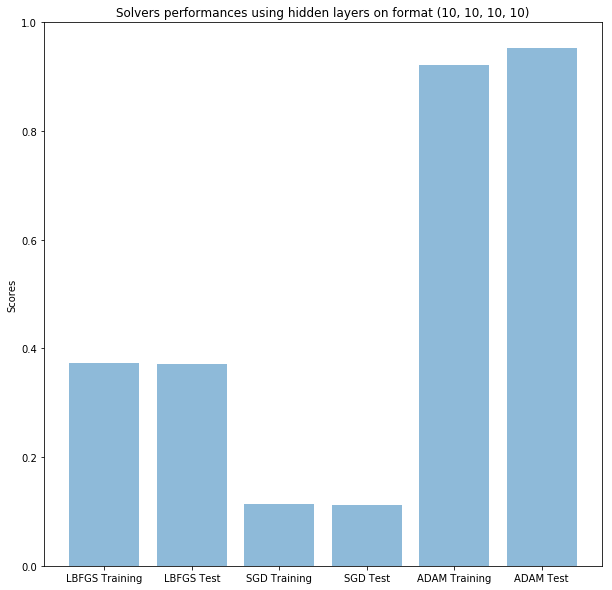

In [41]:
objects = ("LBFGS Training", "LBFGS Test" , "SGD Training", "SGD Test", "ADAM Training", "ADAM Test")

scores = []

scores.append(lbfgs_test_scores[0])
scores.append(lbfgs_training_scores[0])
scores.append(sgd_test_scores[0])
scores.append(sgd_training_scores[0])
scores.append(adam_test_scores[0])
scores.append(adam_training_scores[0])

y_pos = np.arange(len(objects))

plt.bar(y_pos, scores, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Scores')
plt.title(f"Solvers performances using hidden layers on format {hidden_layers[0]}")

plt.show()

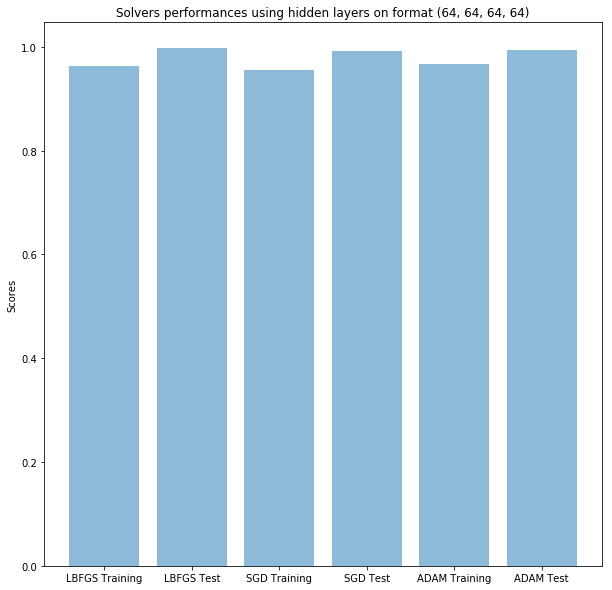

In [42]:
objects = ("LBFGS Training", "LBFGS Test" , "SGD Training", "SGD Test", "ADAM Training", "ADAM Test")

scores = []

scores.append(lbfgs_test_scores[1])
scores.append(lbfgs_training_scores[1])
scores.append(sgd_test_scores[1])
scores.append(sgd_training_scores[1])
scores.append(adam_test_scores[1])
scores.append(adam_training_scores[1])

y_pos = np.arange(len(objects))

plt.bar(y_pos, scores, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Scores')
plt.title(f"Solvers performances using hidden layers on format {hidden_layers[1]}")

plt.show()

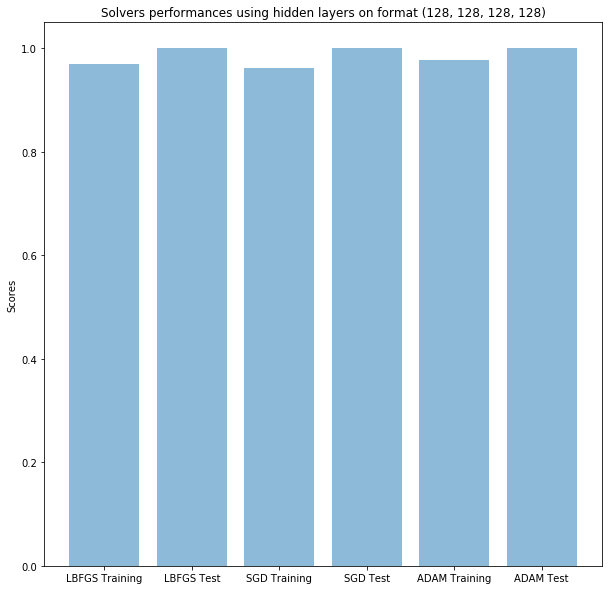

In [43]:
objects = ("LBFGS Training", "LBFGS Test" , "SGD Training", "SGD Test", "ADAM Training", "ADAM Test")

scores = []

scores.append(lbfgs_test_scores[2])
scores.append(lbfgs_training_scores[2])
scores.append(sgd_test_scores[2])
scores.append(sgd_training_scores[2])
scores.append(adam_test_scores[2])
scores.append(adam_training_scores[2])

y_pos = np.arange(len(objects))

plt.bar(y_pos, scores, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Scores')
plt.title(f"Solvers performances using hidden layers on format {hidden_layers[2]}")

plt.show()

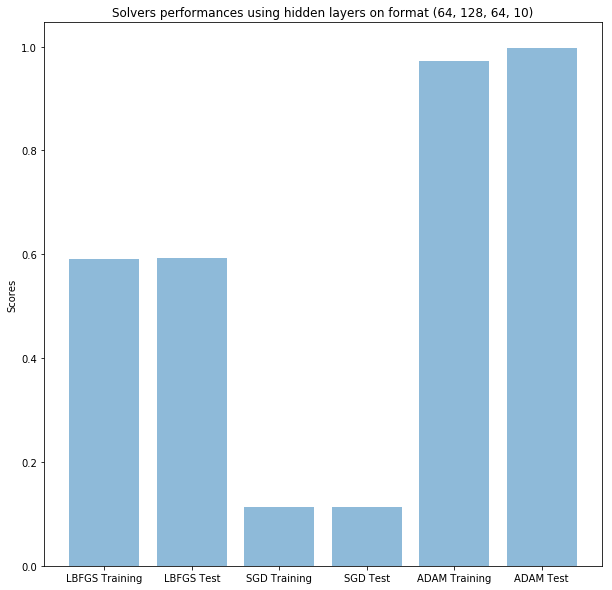

In [44]:
objects = ("LBFGS Training", "LBFGS Test" , "SGD Training", "SGD Test", "ADAM Training", "ADAM Test")

scores = []

scores.append(lbfgs_test_scores[3])
scores.append(lbfgs_training_scores[3])
scores.append(sgd_test_scores[3])
scores.append(sgd_training_scores[3])
scores.append(adam_test_scores[3])
scores.append(adam_training_scores[3])

y_pos = np.arange(len(objects))

plt.bar(y_pos, scores, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Scores')
plt.title(f"Solvers performances using hidden layers on format {hidden_layers[3]}")

plt.show()

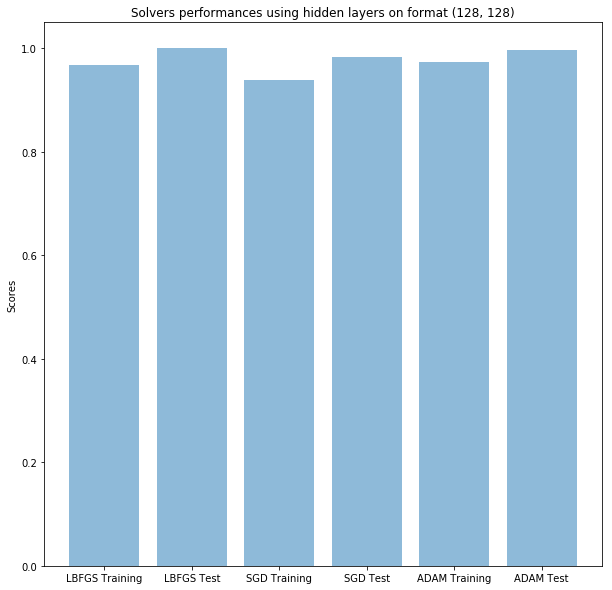

In [45]:
objects = ("LBFGS Training", "LBFGS Test" , "SGD Training", "SGD Test", "ADAM Training", "ADAM Test")

scores = []

scores.append(lbfgs_test_scores[4])
scores.append(lbfgs_training_scores[4])
scores.append(sgd_test_scores[4])
scores.append(sgd_training_scores[4])
scores.append(adam_test_scores[4])
scores.append(adam_training_scores[4])

y_pos = np.arange(len(objects))

plt.bar(y_pos, scores, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Scores')
plt.title(f"Solvers performances using hidden layers on format {hidden_layers[4]}")

plt.show()

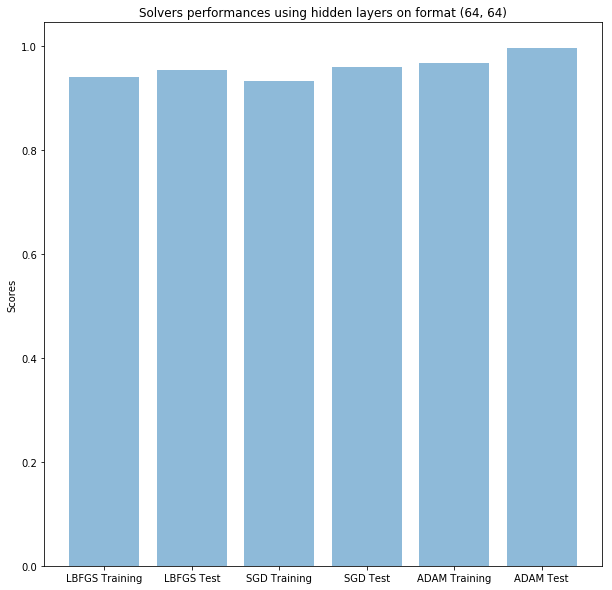

In [46]:
objects = ("LBFGS Training", "LBFGS Test" , "SGD Training", "SGD Test", "ADAM Training", "ADAM Test")

scores = []

scores.append(lbfgs_test_scores[5])
scores.append(lbfgs_training_scores[5])
scores.append(sgd_test_scores[5])
scores.append(sgd_training_scores[5])
scores.append(adam_test_scores[5])
scores.append(adam_training_scores[5])

y_pos = np.arange(len(objects))

plt.bar(y_pos, scores, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Scores')
plt.title(f"Solvers performances using hidden layers on format {hidden_layers[5]}")

plt.show()

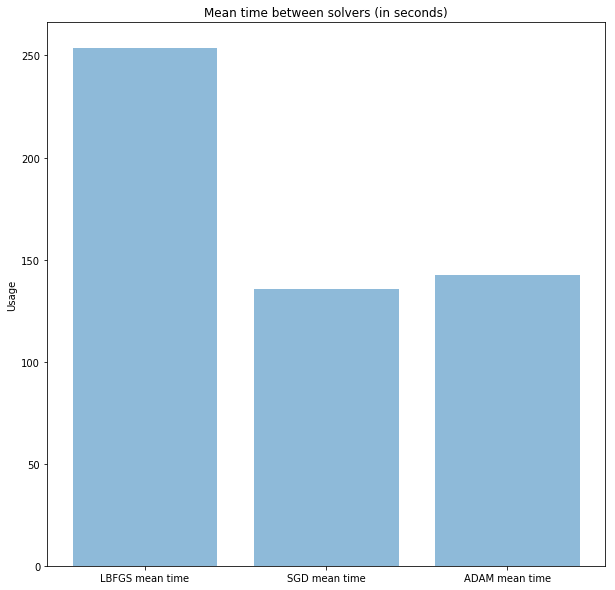

In [48]:
objects = ("LBFGS mean time", "SGD mean time", "ADAM mean time")

scores = []

scores.append(lbfgs_time/6)
scores.append(sgd_time/6)
scores.append(adam_time/6)

y_pos = np.arange(len(objects))

plt.bar(y_pos, scores, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Usage')
plt.title(f"Mean time between solvers (in seconds)")

plt.show()